In [1]:
import datetime
import pathlib
from scipy.io import arff
import pandas as pd
import urllib.request
import io # for io.StringIO()
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
from sklearn import datasets
import seaborn as sn

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00329/messidor_features.arff"
ftpstream = urllib.request.urlopen(url)
diabetics= arff.loadarff(io.StringIO(ftpstream.read().decode('utf-8')))                                  
diabetics=pd.DataFrame(diabetics[0])
print("Matrix before filtering: ", diabetics.shape)
#diabetics=diabetics[diabetics.eq("?").any(1)==False]
diabetics=diabetics.dropna(0)
print("Matrix after filtering: ", diabetics.shape)
#print(diabetics)


Matrix before filtering:  (1151, 20)
Matrix after filtering:  (1151, 20)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  import sys


          0         1         2         3         4         5         6   \
0   1.000000 -0.017611  0.035576  0.035929  0.033395  0.036506  0.034817   
1  -0.017611  1.000000  0.053300  0.054839  0.053056  0.059063  0.060557   
2   0.035576  0.053300  1.000000  0.996177  0.985730  0.963149  0.925274   
3   0.035929  0.054839  0.996177  1.000000  0.994221  0.977030  0.944504   
4   0.033395  0.053056  0.985730  0.994221  1.000000  0.991821  0.968676   
5   0.036506  0.059063  0.963149  0.977030  0.991821  1.000000  0.988294   
6   0.034817  0.060557  0.925274  0.944504  0.968676  0.988294  1.000000   
7   0.031889  0.060152  0.859620  0.883511  0.916198  0.947860  0.974577   
8   0.063597  0.062930 -0.229653 -0.244704 -0.283188 -0.309950 -0.349811   
9   0.063061  0.052453 -0.103047 -0.115253 -0.139111 -0.160011 -0.197279   
10  0.044449  0.053534 -0.044650 -0.058364 -0.086595 -0.109946 -0.152578   
11  0.027656  0.041607  0.103035  0.086486  0.057769  0.029768 -0.020469   
12  0.013336

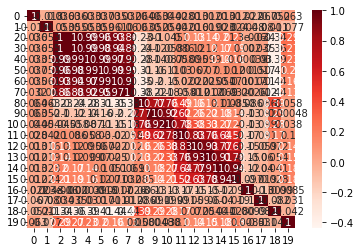

In [3]:
diabetics_corr=diabetics.values[:,:]
diabetics_corr=diabetics_corr.astype(float)
#for i in range(len(diabetics_corr[:,19:20])):
 #   if (diabetics_corr[:,19:20][i]==0.0):
  #   diabetics_corr[:,19:20][i]=2
diabetics_corr=pd.DataFrame(diabetics_corr)
pd.set_option("display.max_rows", None, "display.max_columns", None)
cor=diabetics_corr.corr()

lst = cor.values.tolist()
#for i in range(len(lst)):
   # lst.remove(1.00000)
   # print( max(cor.values.tolist()[i]))
   

print(cor)
sn.heatmap(cor, annot=True, cmap=plt.cm.Reds)

In [4]:
#define the metric we will use to measure similarity
#if the input shapes are [1,N1,F] and [N2,1,F] then output shape is [N2,N1]
#as numpy supports broadcasting with arithmetic operations
#for more on numpy broadcasting refer to: https://numpy.org/doc/stable/user/basics.broadcasting.html   
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2,axis = -1))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)
minkowski = lambda x1, x2: np.power(np.sum(np.abs(x1 - x2)**3,axis = -1), 1/3)


class KNN:

    def __init__(self, K=1, dist_fn= euclidean):
        self.dist_fn = dist_fn                                                    #we need to use self because the parameters would be stored in variables 
                                                                                  #on the stack and would be discarded when the init method goes out of scope
        self.K = K
        return
    
    def fit(self, x, y):
        ''' Store the training data using this method as it is a lazy learner'''
        self.x = x
        self.y = y
        self.C = np.max(y) + 1
        return self
    
    def predict(self, x_test):
        ''' Makes a prediction using the stored training data and the test data given as argument'''
        
        num_test = x_test.shape[0]
        #calculate distance between the training & test samples and returns an array of shape [num_test, num_train]
                
        distances = self.dist_fn(self.x[None,:,:], x_test[:,None,:])
        # print("The shape of the distances is", distances.shape)                          
        #When operating on two arrays, NumPy compares their shapes element-wise. 
        #It starts with the trailing dimensions, and works its way forward. Two dimensions are compatible when: they are equal, or one of them is 1

        #ith-row of knns stores the indices of k closest training samples to the ith-test sample 
        knns = np.zeros((num_test, self.K), dtype=int)
        
        #ith-row of y_prob has the probability distribution over C classes
        y_prob = np.zeros((num_test, self.C))
        for i in range(num_test):
            knns[i,:] = np.argsort(distances[i])[:self.K]  
            y_prob[i,:] = np.bincount(self.y[knns[i,:]], minlength=self.C) #counts the number of instances of each class in the K-closest training samples
        #y_prob /= np.sum(y_prob, axis=-1, keepdims=True)
        #simply divide by K to get a probability distribution
        y_prob /= self.K                                                          #nd you just divided by K so that we scale the value from zero to 1.
        return y_prob, knns

In [5]:
class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices                    
        self.left = None                                  
        self.right = None                                   
        self.split_feature = None                           
        self.split_value = None                             
        if parent:
            self.depth = parent.depth + 1                    
            self.num_classes = parent.num_classes      
            self.data = parent.data                         
            self.labels = parent.labels                     
            class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes) 
            self.class_prob = class_prob / np.sum(class_prob)

In [6]:
def greedy_test(node, cost_fn):
    #initialize the best parameter values
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances, num_features = node.data.shape
    #sort the features to get the test value candidates by taking the average of consecutive sorted feature values 
    data_sorted = np.sort(node.data[node.data_indices],axis=0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.
    for f in range(num_features):
        #stores the data corresponding to the f-th feature
        data_f = node.data[node.data_indices, f]
        for test in test_candidates[:,f]:
            #Split the indices using the test value of f-th feature
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]
            #we can't have a split where a child has zero element
            #if this is true over all the test features and their test values  then the function returns the best cost as infinity
            if len(left_indices) == 0 or len(right_indices) == 0:                
                continue
            #compute the left and right cost based on the current split                                                         
            left_cost = cost_fn(node.labels[left_indices])
            right_cost = cost_fn(node.labels[right_indices])
            num_left, num_right = left_indices.shape[0], right_indices.shape[0]
            #get the combined cost using the weighted sum of left and right cost
            cost = (num_left * left_cost + num_right * right_cost)/num_instances
            #update only when a lower cost is encountered
            if cost < best_cost:
                best_cost = cost
                best_feature = f
                best_value = test
    return best_cost, best_feature, best_value

In [7]:
#computes misclassification cost by subtracting the maximum probability of any class
def cost_misclassification(labels):
    counts = np.bincount(labels) 
    class_probs = counts / np.sum(counts)
    #you could compress both the steps above by doing class_probs = np.bincount(labels) / len(labels)
    return 1 - np.max(class_probs)

#computes entropy of the labels by computing the class probabilities
def cost_entropy(labels):
    class_probs = np.bincount(labels) / len(labels)
    class_probs = class_probs[class_probs > 0]              #this steps is remove 0 probabilities for removing numerical issues while computing log
    return -np.sum(class_probs * np.log(class_probs))       #expression for entropy -\sigma p(x)log[p(x)]

#computes the gini index cost
def cost_gini_index(labels):
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.sum(np.square(class_probs))

In [8]:
class DecisionTree:
    def __init__(self, num_classes=None, max_depth=3, cost_fn=cost_misclassification, min_leaf_instances=1):
        self.max_depth = max_depth      #maximum dept for termination 
        self.root = None                #stores the root of the decision tree 
        self.cost_fn = cost_fn          #stores the cost function of the decision tree 
        self.num_classes = num_classes  #stores the total number of classes
        self.min_leaf_instances = min_leaf_instances  #minimum number of instances in a leaf for termination
        
    def fit(self, data, labels):
        pass                            #pass in python 3 means nothing happens and the method here is empty
    
    def predict(self, data_test):
        pass

In [9]:
def fit(self, data, labels):
    self.data = data
    self.labels = labels
    if self.num_classes is None:
        self.num_classes = np.max(labels) + 1
    #below are initialization of the root of the decision tree
    self.root = Node(np.arange(data.shape[0]), None)
    self.root.data = data
    self.root.labels = labels
    self.root.num_classes = self.num_classes
    self.root.depth = 0
    #to recursively build the rest of the tree
    self._fit_tree(self.root)
    return self

def _fit_tree(self, node):
    #This gives the condition for termination of the recursion resulting in a leaf node
    if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
        return
    #greedily select the best test by minimizing the cost
    cost, split_feature, split_value = greedy_test(node, self.cost_fn)
    #if the cost returned is infinity it means that it is not possible to split the node and hence terminate
    if np.isinf(cost):
        return
    #print(f'best feature: {split_feature}, value {split_value}, cost {cost}')
    #to get a boolean array suggesting which data indices corresponding to this node are in the left of the split
    test = node.data[node.data_indices,split_feature] <= split_value
    #store the split feature and value of the node
    node.split_feature = split_feature
    node.split_value = split_value
    #define new nodes which are going to be the left and right child of the present node
    left = Node(node.data_indices[test], node)
    right = Node(node.data_indices[np.logical_not(test)], node)
    #recursive call to the _fit_tree()
    self._fit_tree(left)
    self._fit_tree(right)
    #assign the left and right child to present child
    node.left = left
    node.right = right

DecisionTree.fit = fit
DecisionTree._fit_tree = _fit_tree

In [10]:
def predict(self, data_test):
    class_probs = np.zeros((data_test.shape[0], self.num_classes))
    for n, x in enumerate(data_test):
        node = self.root
        #loop along the dept of the tree looking region where the present data sample fall in based on the split feature and value
        while node.left:
            if x[node.split_feature] <= node.split_value:
                node = node.left
            else:
                node = node.right
        #the loop terminates when you reach a leaf of the tree and the class probability of that node is taken for prediction
        class_probs[n,:] = node.class_prob
    return class_probs

DecisionTree.predict = predict

In [11]:
x, y = diabetics.values[:,[2,3]], diabetics.values[:,19:20]
print(x)
print(y)
y=y.ravel()
x=x.astype(float)
y=y.astype(int)


for i in range(len(y)):
    if (y[i]==0):
     y[i]=2

(num_instances, num_features), num_classes = x.shape, np.max(y)+1
np.random.seed(1234)
inds = np.random.permutation(num_instances)
#train-test split)
x_train, y_train = x[inds[:800]], y[inds[:800]]
x_test, y_test = x[inds[800:]], y[inds[800:]]

x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)

#to features values as a mesh  
x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

[[22.0 22.0]
 [24.0 24.0]
 [62.0 60.0]
 ...
 [49.0 48.0]
 [39.0 36.0]
 [7.0 7.0]]
[[b'0']
 [b'0']
 [b'1']
 ...
 [b'0']
 [b'1']
 [b'0']]


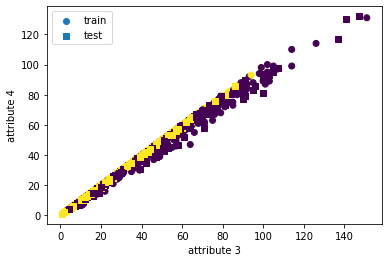

In [12]:

#visualization of the data
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, marker='o', label='train')
plt.scatter(x_test[:,0], x_test[:,1], c=y_test, marker='s', label='test')
plt.legend()
plt.ylabel('attribute 4')
plt.xlabel('attribute 3')
plt.show()

In [13]:
def evaluate_acc(y_test,y_pred):
  return np.sum(y_pred == y_test)/y_test.shape[0]

1


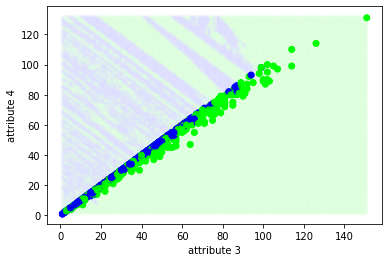

2


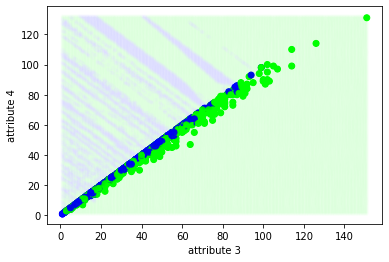

3


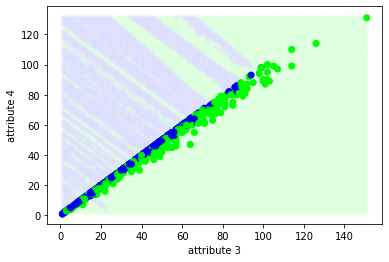

4


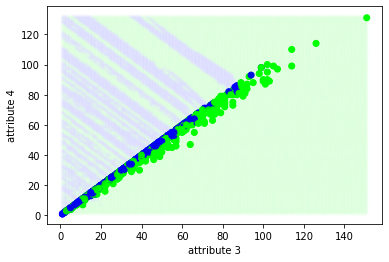

5


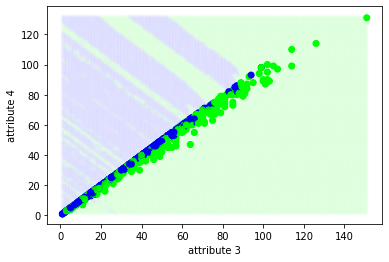

6


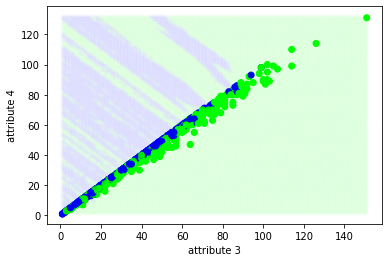

7


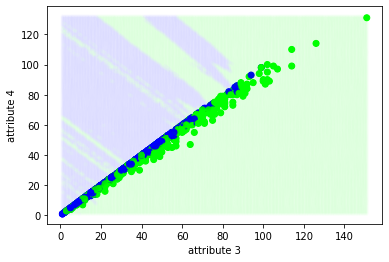

8


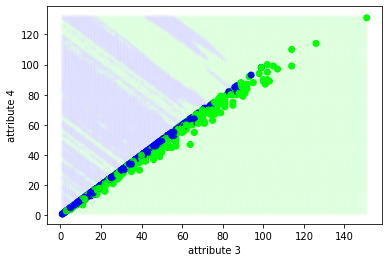

9


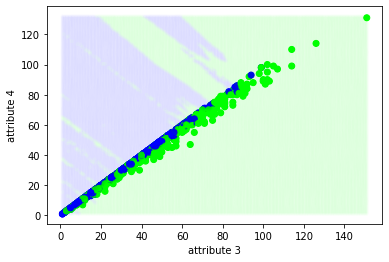

10


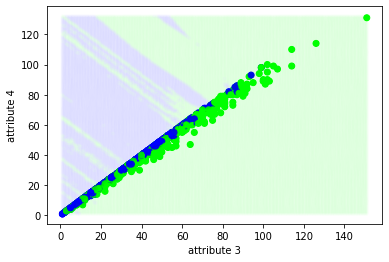

11


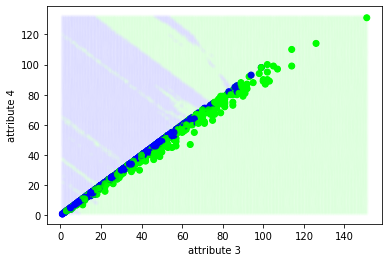

12


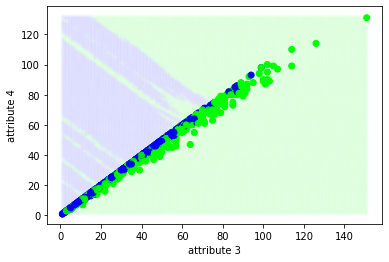

13


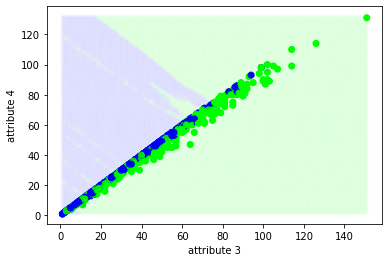

14


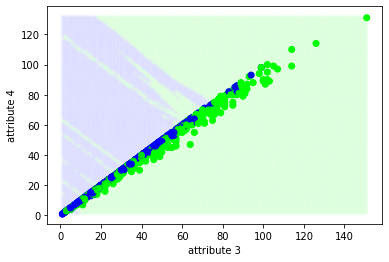

15


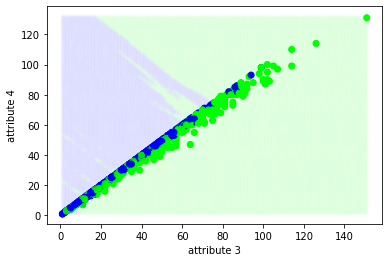

16


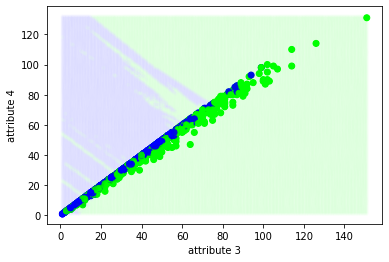

17


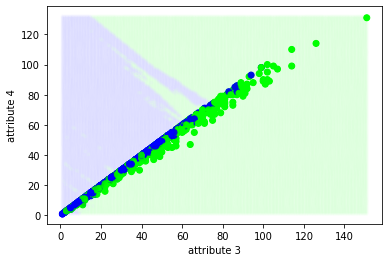

18


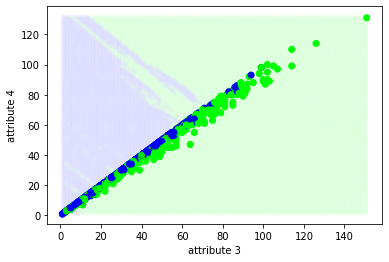

19


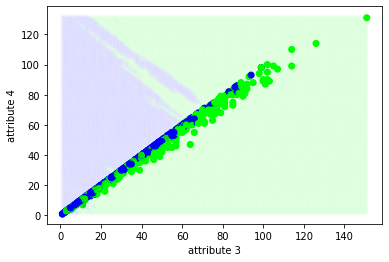

20


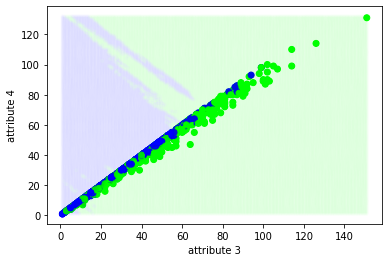

21


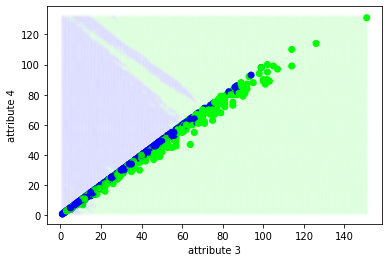

22


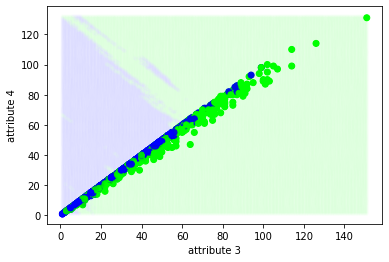

23


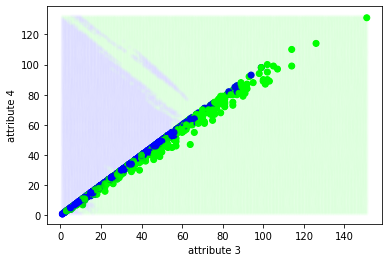

24


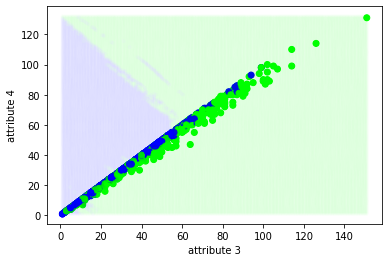

25


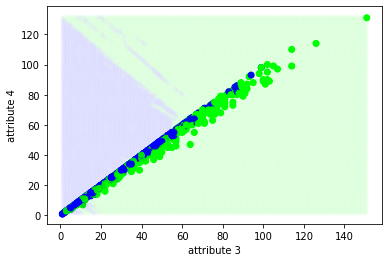

26


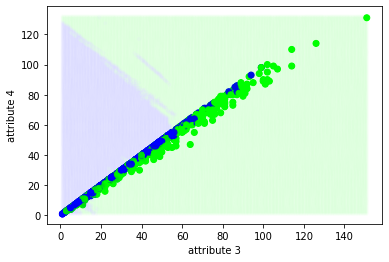

27


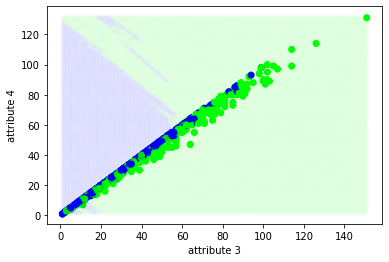

28


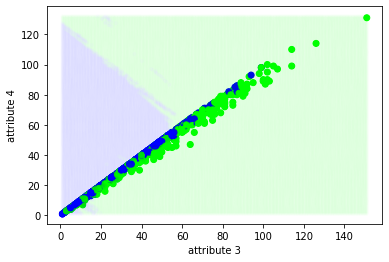

29


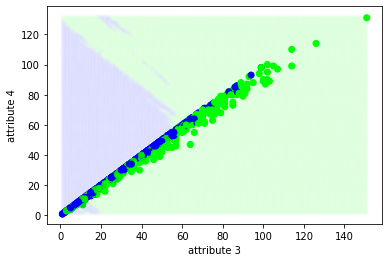

30


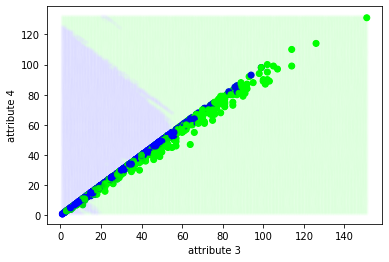

31


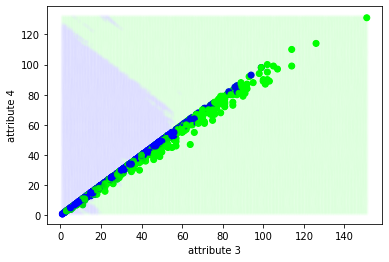

32


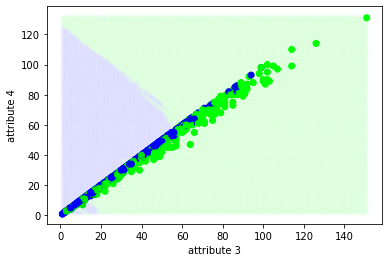

33


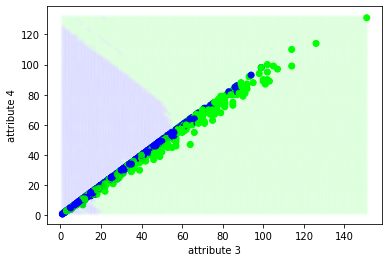

34


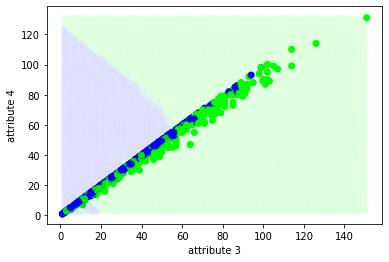

35


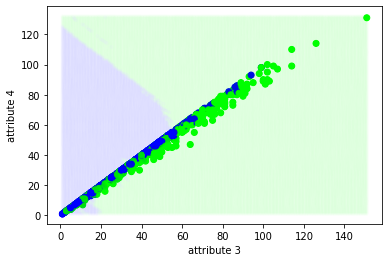

36


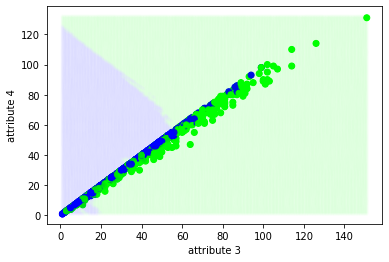

37


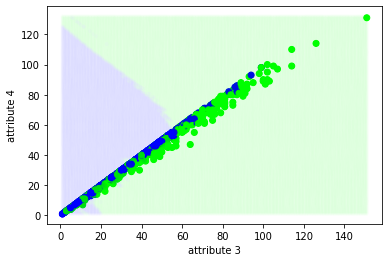

38


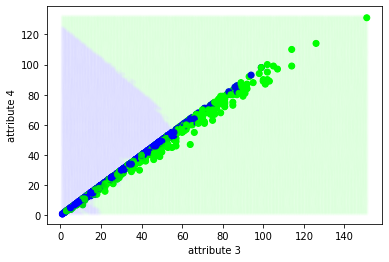

39


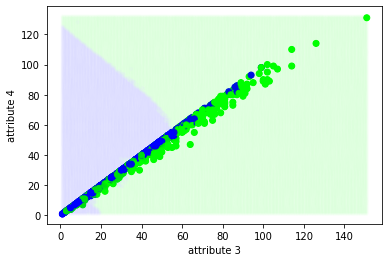

40


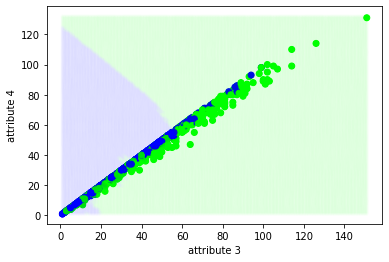

41


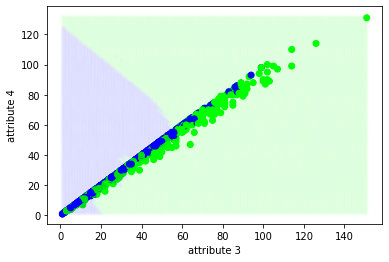

42


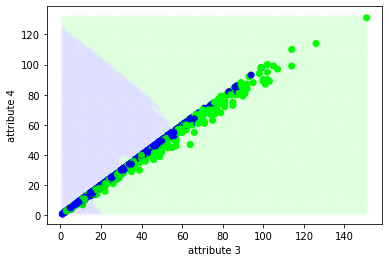

43


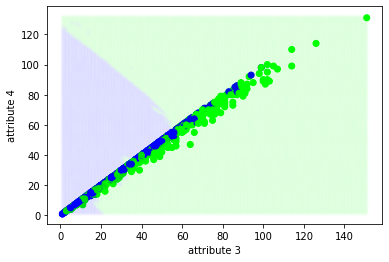

44


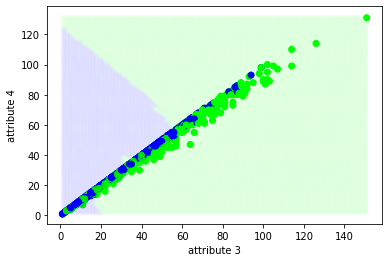

45


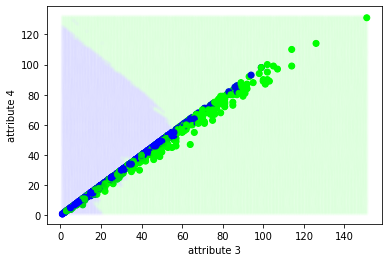

46


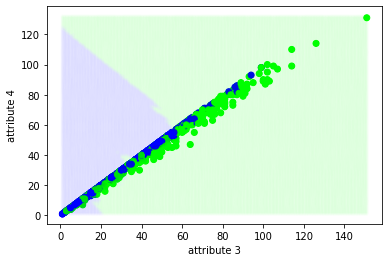

47


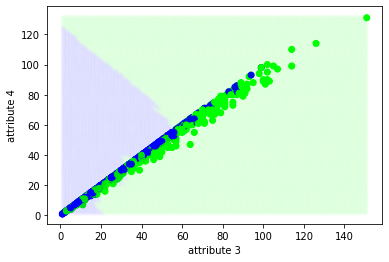

48


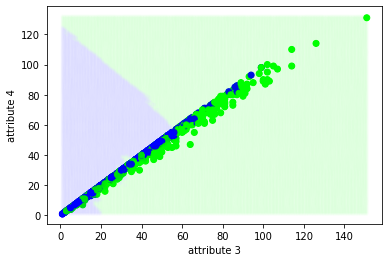

49


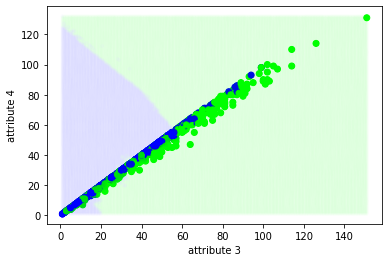

50


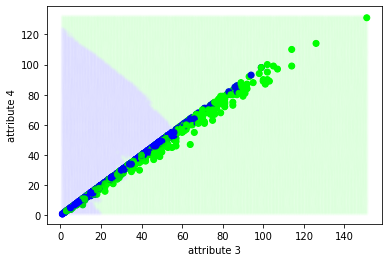

51


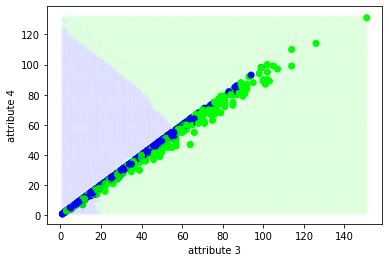

52


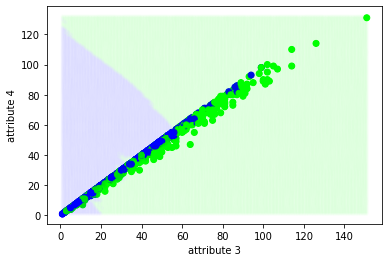

53


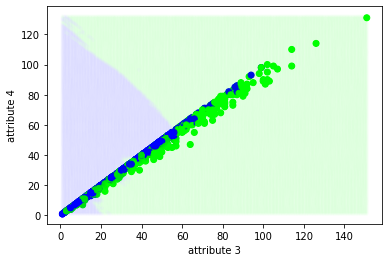

54


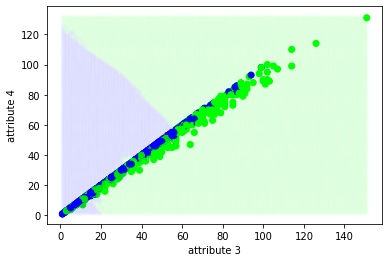

55


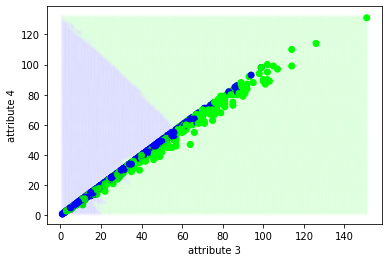

56


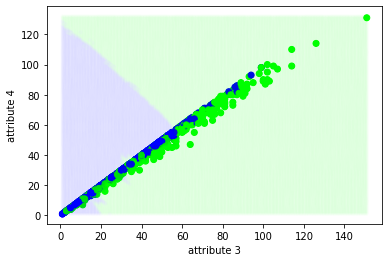

57


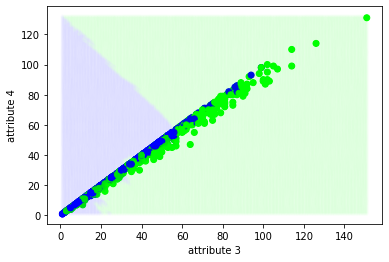

58


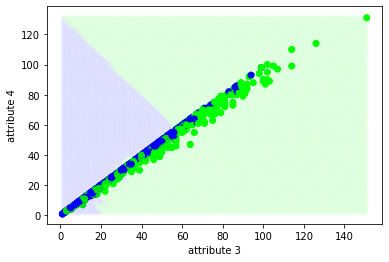

59


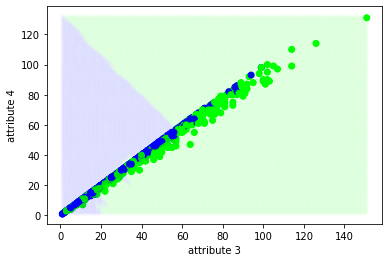

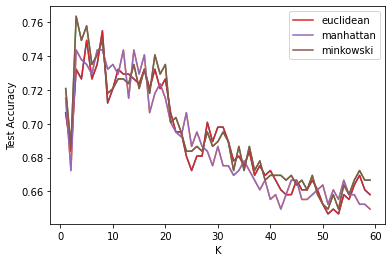

0.7549857549857549
0.7435897435897436
0.7635327635327636
8
.     
3
.     
3
For KNN, 
Max accuracy is 0.7549857549857549 when K=8
Min accuracy is 0.6467236467236467 when K=51


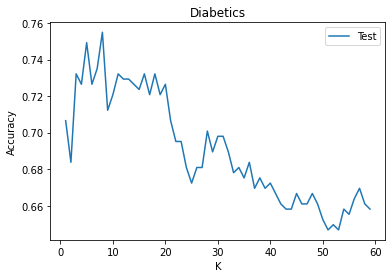

In [16]:
acc_lst, K_lst = [], []
acc_lst_m = []
acc_lst_m1 = []
for k in range(1, 60):
    model_m1 = KNN(k, dist_fn = minkowski)
    model_m = KNN(k, dist_fn=manhattan)
    model = KNN(k)
    y_prob, knns = model.fit(x, y).predict(x_test)
    y_prob_m, knns_m = model_m.fit(x, y).predict(x_test)
    y_prob_m1, knns_m1 = model_m1.fit(x, y).predict(x_test)
    y_pred = np.argmax(y_prob, axis=-1)
    y_pred_m = np.argmax(y_prob_m, axis=-1)
    y_pred_m1 = np.argmax(y_prob_m1, axis=-1)
    accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
    accuracy_m = np.sum(y_pred_m == y_test) / y_test.shape[0]
    accuracy_m1 = np.sum(y_pred_m1 == y_test) / y_test.shape[0]
    acc_lst.append(accuracy)
    acc_lst_m.append(accuracy_m)
    acc_lst_m1.append(accuracy_m1)
    K_lst.append(k)
    #plot the decision boundary
    print(k)
    y_train_prob = np.zeros((y_train.shape[0], num_classes))
    y_train_prob[np.arange(y_train.shape[0]), y_train] = 1

    #to get class probability of all the points in the 2D grid
    y_prob_all, _ = model.fit(x_train, y_train).predict(x_all)

    y_pred_all = np.zeros_like(y_prob_all)
    y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1

    plt.scatter(x_train[:,0], x_train[:,1], c=y_train_prob, marker='o', alpha=1)
    plt.scatter(x_all[:,0], x_all[:,1], c=y_pred_all, marker='.', alpha=0.01)
    plt.ylabel('attribute 4')
    plt.xlabel('attribute 3')
    plt.show()
#plot accuracy graph for different distance function
plt.xlabel('K')
plt.ylabel('Test Accuracy')
plt.plot(K_lst, acc_lst)
plt.plot(K_lst, acc_lst_m)
plt.plot(K_lst, acc_lst_m1)
line1, = plt.plot(K_lst, acc_lst, label='euclidean')
line2, = plt.plot(K_lst, acc_lst_m, label='manhattan')
line3, = plt.plot(K_lst, acc_lst_m1, label='minkowski')
plt.legend(handles=[line1, line2,line3], loc='upper right')
plt.show()
print(max(acc_lst))
print(max(acc_lst_m))
print(max(acc_lst_m1))
for i in range(len(acc_lst)):
  if (acc_lst[i] == max(acc_lst)):
    print(i+1)
    break;

print(".     ")
for i in range(len(acc_lst_m)):
  if (acc_lst_m[i] == max(acc_lst_m)):
    print(i+1)
    break;
print(".     ")
for i in range(len(acc_lst_m1)):
  if (acc_lst_m1[i] == max(acc_lst_m1)):
    print(i+1)
    break;
  
# gives the max min accuracy for KNN 
max_value = max(acc_lst)
max_index = acc_lst.index(max_value)
min_value = min(acc_lst)
min_index = acc_lst.index(min_value)

print(f'For KNN, ')
print(f'Max accuracy is {max_value} when K={max_index + 1}')
print(f'Min accuracy is {min_value} when K={min_index + 1}')

#plot graph KNN testing vs. training accuracy
plt.xlabel('K')
plt.ylabel('Accuracy')
line1, = plt.plot([i for i in range(1, 60)], acc_lst, label='Test')
plt.legend(handles=[line1], loc='upper right')
plt.title('Diabetics')
plt.show()



1


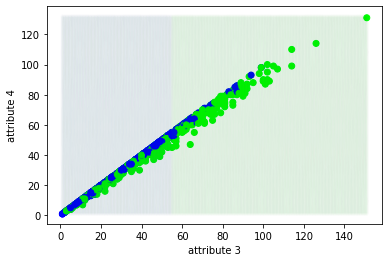

2


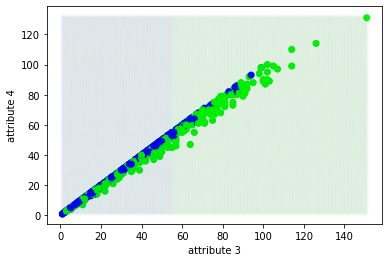

3


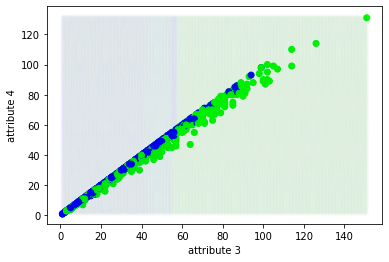

4


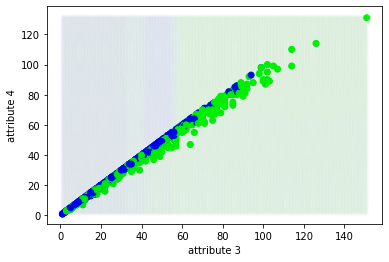

5


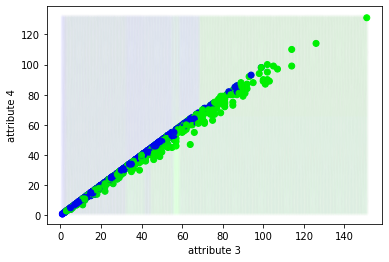

6


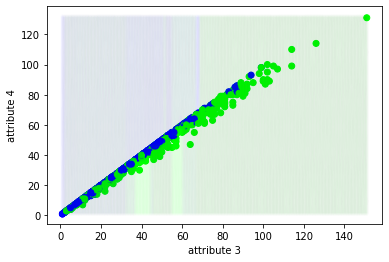

7


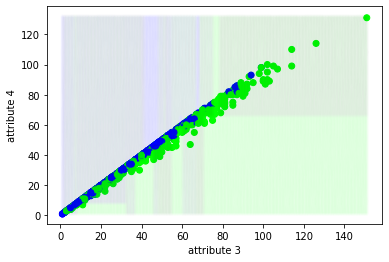

8


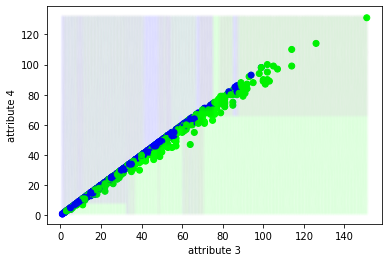

9


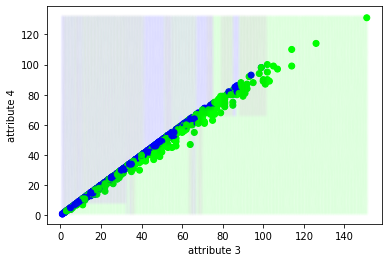

10


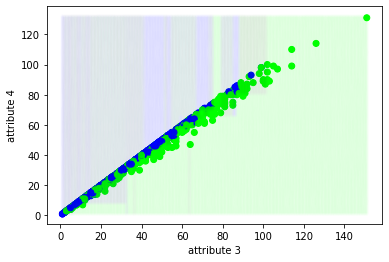

11


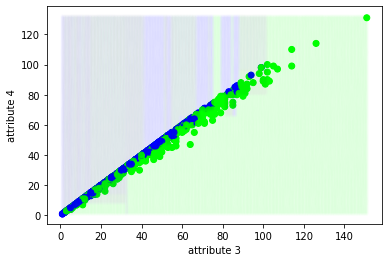

12


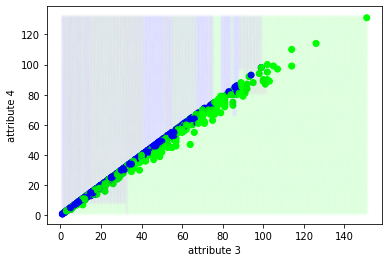

13


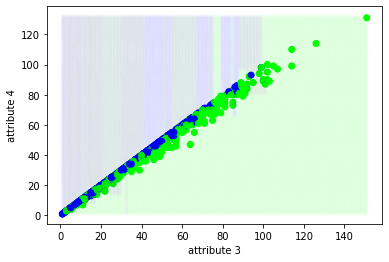

14


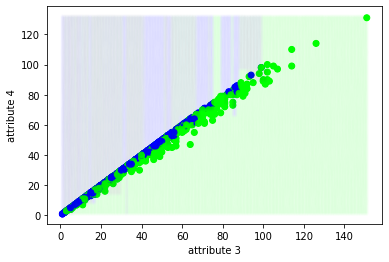

15


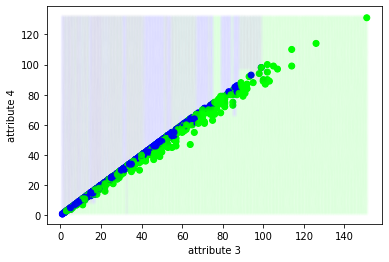

16


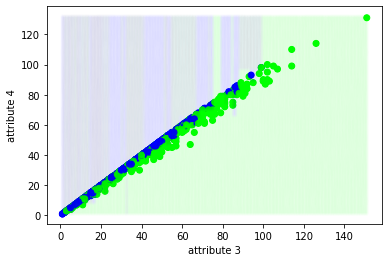

17


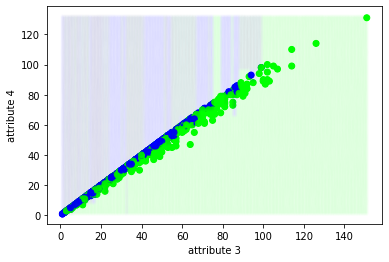

18


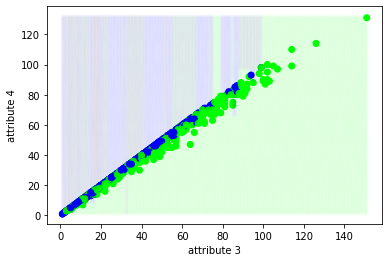

19


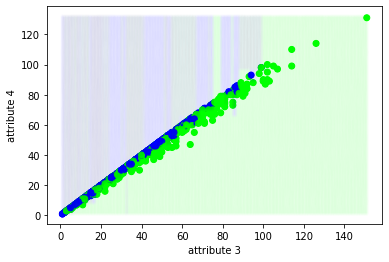

20


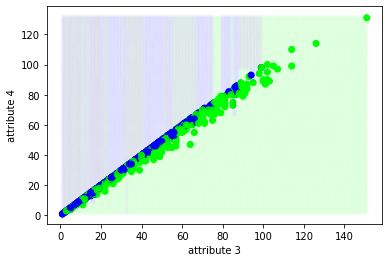

21


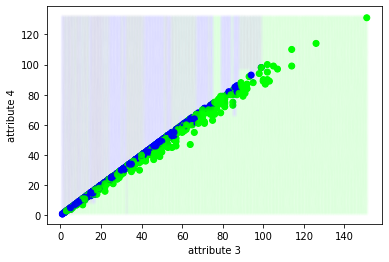

22


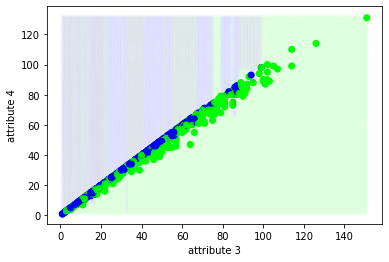

23


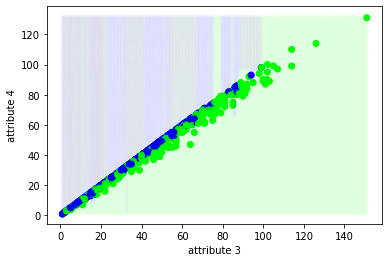

24


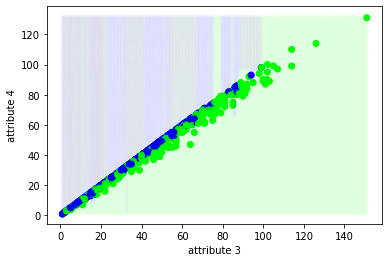

25


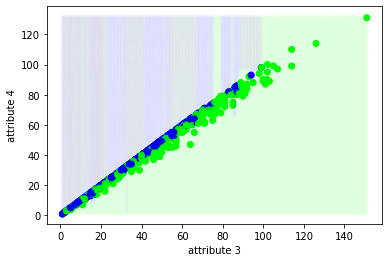

26


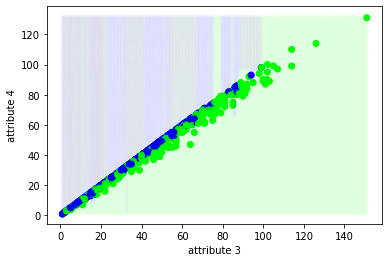

27


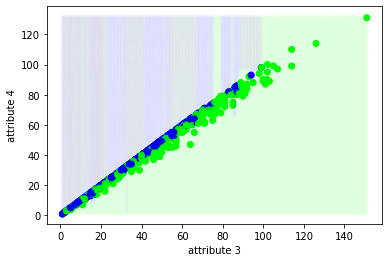

28


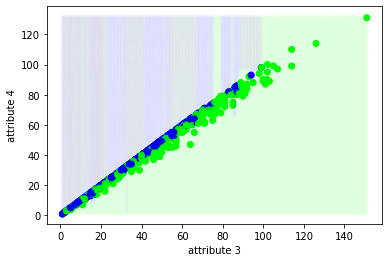

29


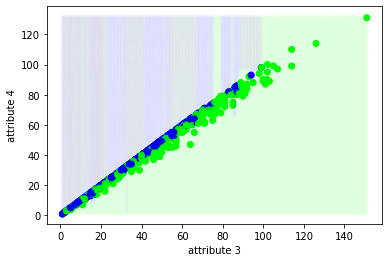

30


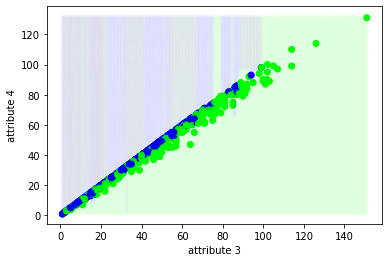

31


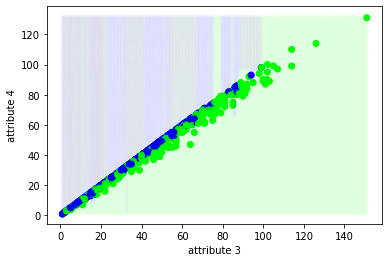

32


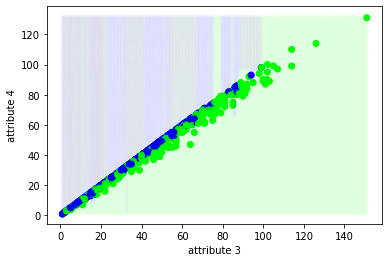

33


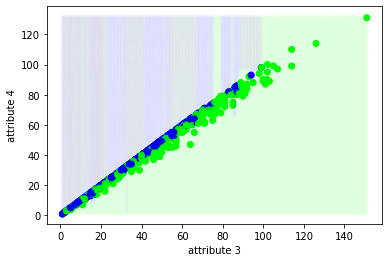

34


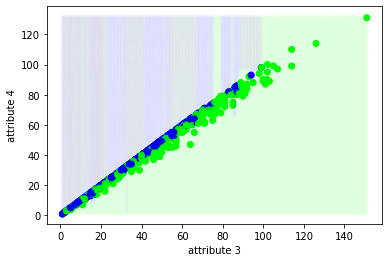

35


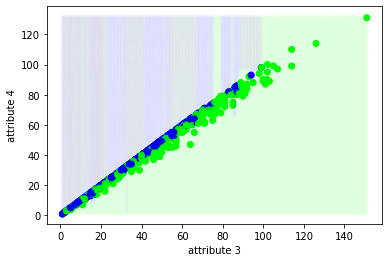

36


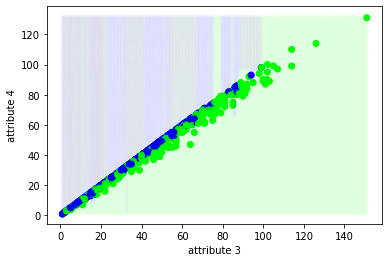

37


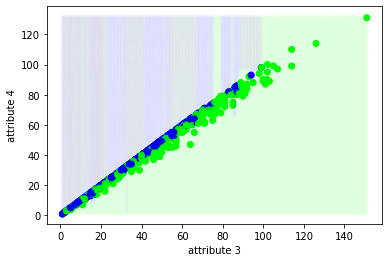

38


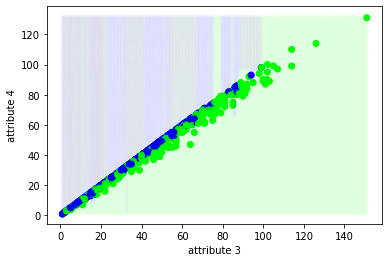

39


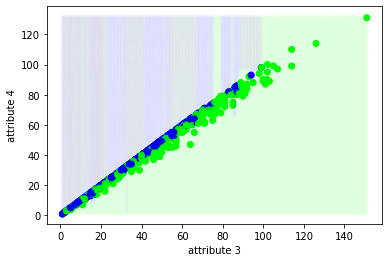

40


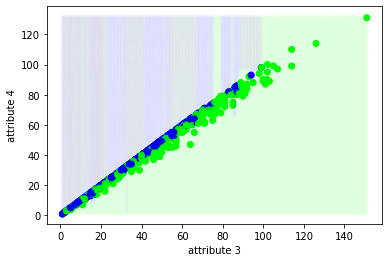

41


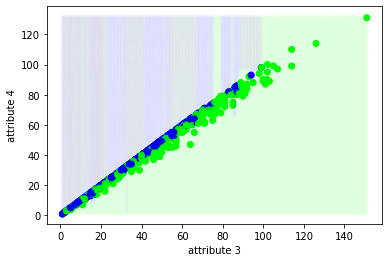

42


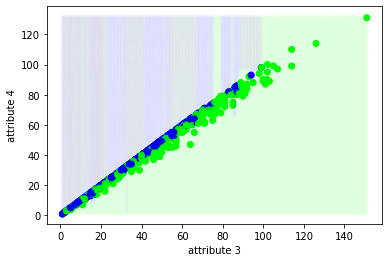

43


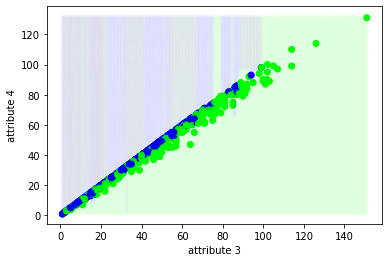

44


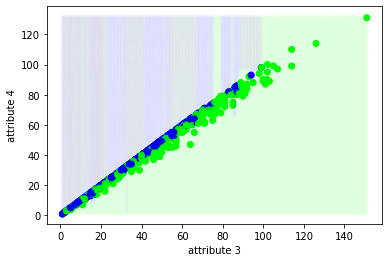

45


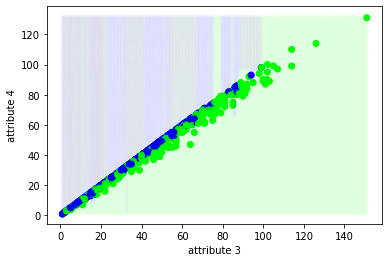

46


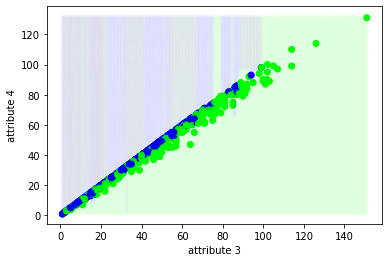

47


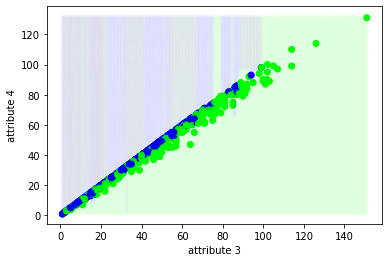

48


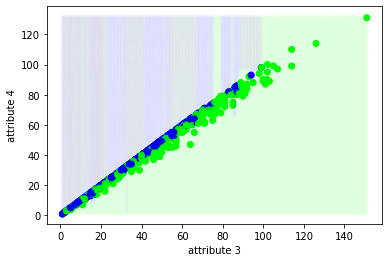

49


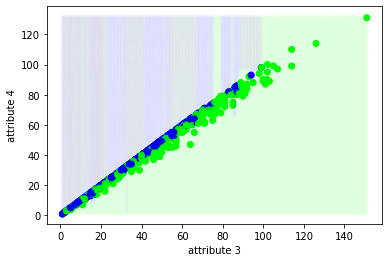

50


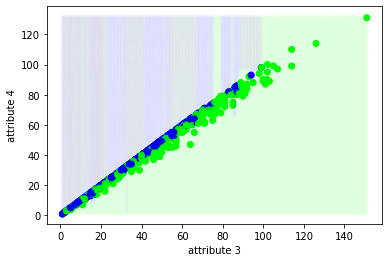

51


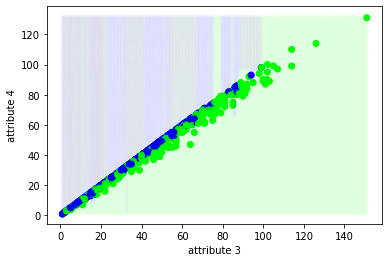

52


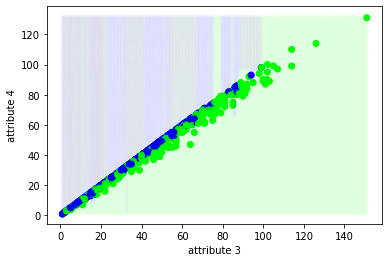

53


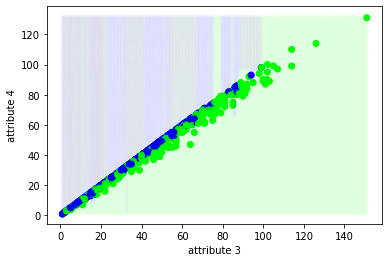

54


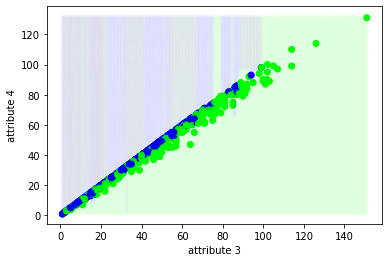

55


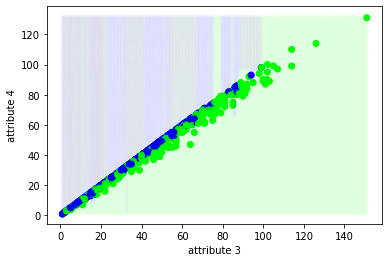

56


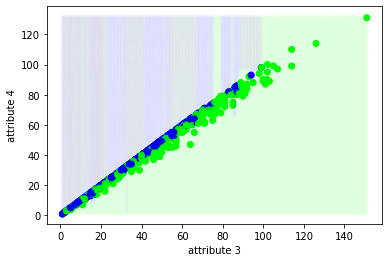

57


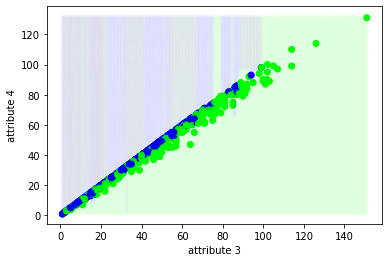

58


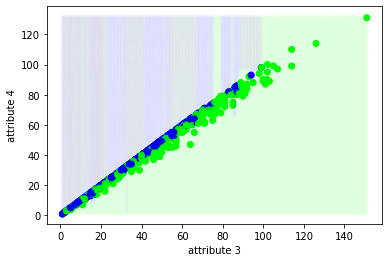

59


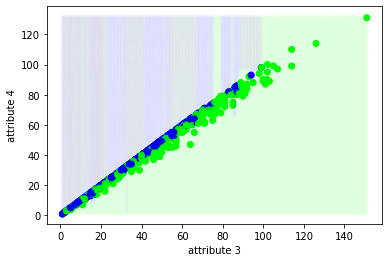

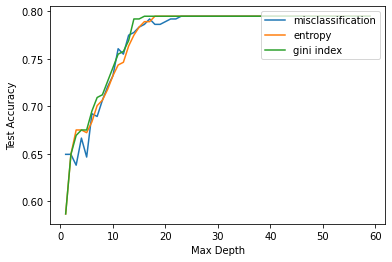

0.7948717948717948
0.7948717948717948
0.7948717948717948
23
.     
18
.     
16
For DecisionTree, 
Max accuracy is 0.7948717948717948 when max_depth is 23
Min accuracy is 0.6381766381766382 when max_depth is 3


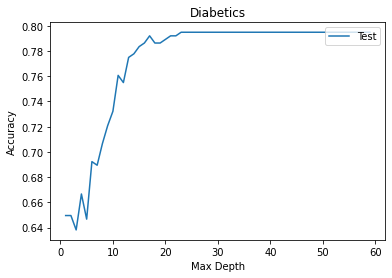

In [17]:
acc_lst = []
acc_lst_e = []
acc_lst_g = []
for mx_d in range(1, 60):
    tree = DecisionTree(max_depth=mx_d)
    tree_e = DecisionTree(max_depth=mx_d, cost_fn=cost_entropy)
    tree_g = DecisionTree(max_depth=mx_d, cost_fn=cost_gini_index)
    probs_test = tree.fit(x, y).predict(x_test)
    probs_test_e = tree_e.fit(x, y).predict(x_test)
    probs_test_g = tree_g.fit(x, y).predict(x_test)
    y_pred = np.argmax(probs_test, 1)
    y_pred_e = np.argmax(probs_test_e, 1)
    y_pred_g = np.argmax(probs_test_g, 1)
    accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
    accuracy_e = np.sum(y_pred_e == y_test) / y_test.shape[0]
    accuracy_g = np.sum(y_pred_g == y_test) / y_test.shape[0]
    acc_lst.append(accuracy)
    acc_lst_e.append(accuracy_e)
    acc_lst_g.append(accuracy_g)
    #plot the decision boundary
    print(mx_d)
    y_train_prob = np.zeros((y_train.shape[0], num_classes))
    y_train_prob[np.arange(y_train.shape[0]), y_train] = 1
    y_prob_all = tree.fit(x_train, y_train).predict(x_all)
    plt.scatter(x_train[:,0], x_train[:,1], c=y_train_prob, marker='o', alpha=1)
    plt.scatter(x_all[:,0], x_all[:,1], c=y_prob_all, marker='.', alpha=.01)
    plt.ylabel('attribute 4')
    plt.xlabel('attribute 3')
    plt.show()

#plot graph for different cost function
plt.xlabel('Max Depth')
plt.ylabel('Test Accuracy')
line1, = plt.plot([i for i in range(1, 60)], acc_lst, label='misclassification')
line2, = plt.plot([i for i in range(1, 60)], acc_lst_e, label='entropy')
line3, = plt.plot([i for i in range(1, 60)], acc_lst_g, label='gini index')
plt.legend(handles=[line1, line2, line3], loc='upper right')
plt.show()
print(max(acc_lst))
print(max(acc_lst_e))
print(max(acc_lst_g))
for i in range(len(acc_lst)):
  if (acc_lst[i] == max(acc_lst)):
    print(i+1)
    break;

print(".     ")
for i in range(len(acc_lst_e)):
  if (acc_lst_e[i] == max(acc_lst_e)):
    print(i+1)
    break;
print(".     ")
for i in range(len(acc_lst_g)):
  if (acc_lst_g[i] == max(acc_lst_g)):
    print(i+1)
    break;

#find the max and min training and testing value for DT
max_value = max(acc_lst)
max_index = acc_lst.index(max_value)
min_value = min(acc_lst)
min_index = acc_lst.index(min_value)


print(f'For DecisionTree, ')
print(f'Max accuracy is {max_value} when max_depth is {max_index + 1}')
print(f'Min accuracy is {min_value} when max_depth is {min_index + 1}')

#plot graph for DT training vs.testing accuracy
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
line1, = plt.plot([i for i in range(1, 60)], acc_lst, label='Test')
plt.legend(handles=[line1], loc='upper right')
plt.title('Diabetics')
plt.show()

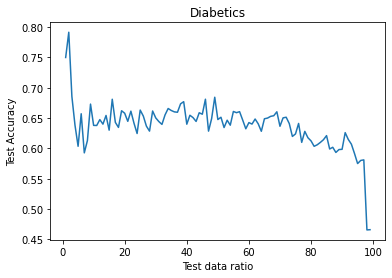

In [ ]:
def helper(x, y, test_ratio):

    split_idx = int(len(y) * (1 - test_ratio))
    x_train,y_train, x_test,y_test = x[inds[:split_idx]], y[inds[:split_idx]],x[inds[split_idx:]],y[inds[split_idx:]]
    return x_train, y_train, x_test, y_test

def extra_experiment_KNN(x,y):
    acc_lst = []
    for i in range(1, 100):
        x_train, y_train, x_test, y_test = helper(x, y, i/100)
        model = KNN(5)
        y_prob, _ = model.fit(x_train, y_train).predict(x_test)
        y_pred = np.argmax(y_prob, axis=-1)
        accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
        acc_lst.append(accuracy)
    plt.xlabel('Test data ratio')
    plt.ylabel('Test Accuracy')
    plt.plot([i for i in range(1, 100)], acc_lst)
    plt.title('Diabetics')
    plt.show()

extra_experiment_KNN(x,y)      
 